In [1]:
from mri.operators import NonCartesianFFT, WaveletUD2, WaveletN
import pysap
from pysap.data import get_sample_data
from mri.operators.utils import convert_mask_to_locations, convert_locations_to_mask
from modopt.math.metrics import ssim
import matplotlib.pyplot as plt
import numpy as np

/home/guillaume/temp/pysap-mri/mri/operators/fourier/cartesian.py:33: UserWarning: pynufft python package has not been found. If needed use the master release. Till then you cannot use NUFFT on GPU
  warnings.warn("pynufft python package has not been found. If needed use "
/home/guillaume/temp/pysap-mri/mri/operators/fourier/non_cartesian.py:33: UserWarning: pynufft python package has not been found. If needed use the master release. Till then you cannot use NUFFT on GPU
  warnings.warn("pynufft python package has not been found. If needed use "



                 .|'''|       /.\      '||'''|,
                 ||          // \\      ||   ||
'||''|, '||  ||` `|'''|,    //...\\     ||...|'
 ||  ||  `|..||   .   ||   //     \\    ||
 ||..|'      ||   |...|' .//       \\. .||
 ||       ,  |'
.||        ''

Package version: 0.0.3

License: CeCILL-B

Authors: 

Antoine Grigis <antoine.grigis@cea.fr>
Samuel Farrens <samuel.farrens@cea.fr>
Jean-Luc Starck <jl.stark@cea.fr>
Philippe Ciuciu <philippe.ciuciu@cea.fr>

Dependencies: 

scipy          : >=1.3.0   - required | 1.3.0     installed
numpy          : >=1.16.4  - required | 1.16.4    installed
matplotlib     : >=3.0.0   - required | 3.1.1     installed
astropy        : >=3.0.0   - required | 3.2.1     installed
nibabel        : >=2.3.2   - required | 2.5.1     installed
pyqtgraph      : >=0.10.0  - required | 0.10.0    installed
progressbar2   : >=3.34.3  - required | ?         installed
modopt         : >=1.4.0   - required | 1.4.1     installed
scikit-learn   : >=0.19.1  - requi

In [2]:
# Lower level imports
from algo.prox import prox_G,prox_F1_dual,prox_F2_dual
from algo.pdhg import pdhg
from algo.cost_utils import *

#Upper level imports
from scipy.sparse.linalg import cg,LinearOperator
import scipy
import time
from algo.upper_level_utils import *
from scipy.optimize.lbfgsb import fmin_l_bfgs_b

In [3]:
u0 = get_sample_data('2d-mri')
u0_mat = u0.data[125:175,125:175]

n=u0_mat.shape[0]
x = np.linspace(0,n,n,endpoint=False)/n-0.5
y = np.linspace(0,n,n,endpoint=False)/n-0.5
X,Y = np.meshgrid(x,y)
kspace_loc = np.stack([X.flatten('F'),Y.flatten('F')],axis=1)

m = convert_locations_to_mask(kspace_loc,u0_mat.shape)
fourier_op = NonCartesianFFT(samples=kspace_loc, shape=u0_mat.shape,implementation='cpu')

y = (1+0j)*fourier_op.op(u0_mat)+3e-7*np.random.randn(2*n*n).view(np.complex128)

/home/guillaume/temp/pysap-mri/mri/operators/fourier/utils.py:78: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mask[test] = 1


In [16]:
#Subsampling: From pysap radial mask 
radial_mask = get_sample_data("mri-radial-samples")
radial_kspace_loc = radial_mask.data
radial_p = np.zeros((n*n+1,))

ind1 = ((n-1)*(radial_kspace_loc[:,0]+0.5)).astype(int)
ind2 = ((n-1)*(radial_kspace_loc[:,1]+0.5)).astype(int)
radial_p[n*ind1+ind2]=1
radial_p[-1]=1e-6
p = np.copy(radial_p)

#Wavelet
linear_op = WaveletN(wavelet_name="sym8",nb_scale=3,padding_mode = "periodization")
#linear_op = WaveletUD2(wavelet_id=24,nb_scale=3)

param = {"zeta":1e15,"pn1":p[-1],"epsilon":1e-5,"gamma":1e-10}


In [17]:
print(ssim(fourier_op.adj_op(y),u0_mat))
pysap.Image(data=fourier_op.adj_op(y)).show()

0.9699086661766413


# Definition of functions
Only for one linear operator for the moment (wavelet).

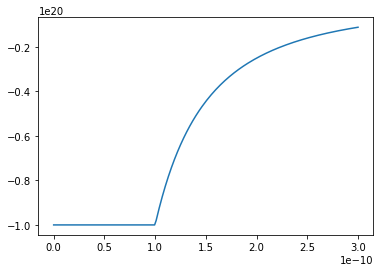

In [18]:
x = np.linspace(0,3*param["gamma"],200)
plt.plot(x,psix_vec(x,param["gamma"]))

# Functions and first order derivatives

In [67]:
#Base functions
def Eeps(x,p):return param["epsilon"]/2*np.linalg.norm(x)**2
def Edata(x,p):return 0.5*np.linalg.norm(p[:-1]*(fourier_op.op(x)-y))**2
def Ereg(x,p):return p[-1]*np.sum(rho_vec(linear_op.op(x),param["gamma"]))
def Etot(x,p):return Eeps(x,p)+Edata(x,p)+Ereg(x,p)

#First order derivatives
def Du_Eeps(x,p):return param["epsilon"]*x
def Du_Edata(x,p):return fourier_op.adj_op(p[:-1]**2*(fourier_op.op(x)-y))
def Du_Ereg(x,p):return p[-1]*linear_op.adj_op(phi_vec(linear_op.op(x),param["gamma"])*linear_op.op(x))
def Du_Etot(x,p):return Du_Eeps(x,p)+Du_Edata(x,p)+Du_Ereg(x,p)

### Numerical check
Plots of $\left|\frac{f(a+th)-f(a)-<\nabla f(a),th>}{t}\right|$ for $t\rightarrow 0$. Eeps, Edata and Enonneg seem to work, but problem with Ereg.

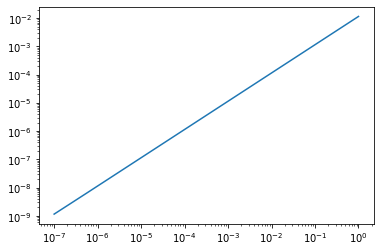

In [60]:
# -- Eeps --
#Two random vectors with same amplitude
a = np.random.randn(n**2).reshape((n,n))
a2 = np.random.randn(n**2).reshape((n,n))

tests = np.logspace(-7,0,20)
real_values = np.array([Eeps(a+t*a2,radial_p) for t in tests])
approx = np.array([Eeps(a,radial_p)+t*np.sum(Du_Eeps(a,radial_p)*a2)for t in tests])

plt.plot(tests,np.abs((real_values-approx)/tests))
plt.xscale("log")
plt.yscale("log")

1.655590486278352e-10


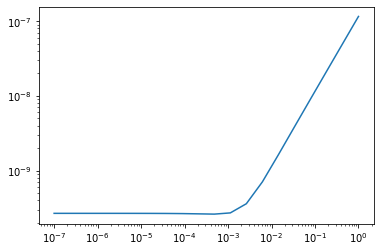

In [91]:
# -- Edata --
#Random vector with same amplitude as u0
a = u0_mat
#a = np.random.randn(2*n**2).view(np.complex128).reshape((n,n))/n*np.linalg.norm(u0_mat)
a2 = np.random.randn(2*n**2).view(np.complex128).reshape((n,n))/n*np.linalg.norm(u0_mat)

p=radial_p
tests = np.logspace(-7,0,20)
real_values = np.array([Edata(a+t*a2,radial_p) for t in tests])
approx = np.array([Edata(a,radial_p)+t*np.sum(Du_Edata(a,radial_p)*a2)for t in tests])

print(Edata(a,radial_p))
plt.plot(tests,np.abs((real_values-approx)/tests))
plt.xscale("log")
plt.yscale("log")

1.5974211636410945e-08


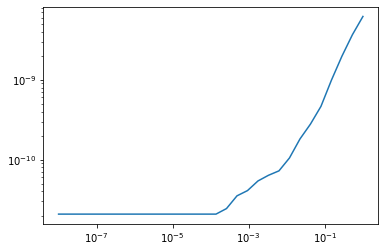

In [84]:
# -- Ereg --
#Random vector with same amplitude as u0
a = np.random.randn(n**2).reshape((n,n))/n*np.linalg.norm(u0_mat)
#a=u0_mat
a2 = np.random.randn(n**2).reshape((n,n))/n*np.linalg.norm(u0_mat)

tests = np.logspace(-8,-0,30)
real_values = np.array([Ereg(a+t*a2,radial_p) for t in tests])
approx = np.array([Ereg(a,radial_p)+t*np.sum(Du_Ereg(a,radial_p)*a2) for t in tests])

print(Ereg(a,radial_p))
plt.plot(tests,np.abs((real_values-approx)/tests))
plt.xscale("log")
plt.yscale("log")

Gap between limits:2.0819143401224643e-19


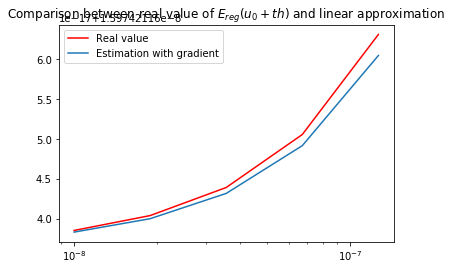

In [85]:
print(f"Gap between limits:{real_values[0]-approx[0]}")

plt.plot(tests[:5],real_values[:5],'r',label="Real value")
plt.plot(tests[:5],approx[:5],label="Estimation with gradient")
plt.xscale("log")
plt.title("Comparison between real value of $E_{reg}(u_0+th)$ and linear approximation")
plt.legend()

1.4445337637919745e-07


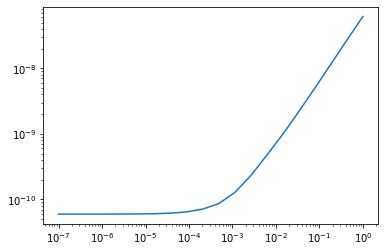

In [68]:
# -- Etot --
#Random vector with same amplitude as u0
a2 = np.random.randn(n**2).reshape((n,n))/n*np.linalg.norm(u0_mat)
a = np.random.randn(n**2).reshape((n,n))/n*np.linalg.norm(u0_mat)
#a=u0_mat

tests = np.logspace(-7,0,20)
real_values = np.array([Etot(a+t*a2,radial_p) for t in tests])
approx = np.array([Etot(a,radial_p)+t*np.sum(Du_Etot(a,radial_p)*a2)for t in tests])

print(Etot(a,radial_p))
plt.plot(tests,(real_values-approx)/tests)
plt.xscale("log")
plt.yscale("log")

# Second order derivatives
We don't express the hessians as matrices but as linear operators. Same verifications: $\frac{||\nabla f(a+th)-(\nabla f(a)+t\nabla^2f(a)h)||_2}{t}$.

In [69]:
def Du2_Eeps(u,p,w):return param["epsilon"]*w
def Du2_Edata(u,p,w):return fourier_op.adj_op(p[:-1]**2*fourier_op.op(w))
def Du2_Ereg(u,p,w):
    lin_u = linear_op.op(u)
    lin_w = linear_op.op(w)
    psi_Au = psix_vec(lin_u,param["gamma"])
    phi_Au = phi_vec(lin_u,param["gamma"])
    
    part1 = psi_Au*lin_u*(np.real(lin_u)*np.real(lin_w)+1j*np.imag(lin_u)+np.imag(lin_w))
    part2 = phi_Au*lin_w
    return p[-1]*(linear_op.adj_op(part1+part2))
def Du2_Etot(u,p,w):return Du2_Eeps(u,p,w)+Du2_Edata(u,p,w)+Du2_Ereg(u,p,w)

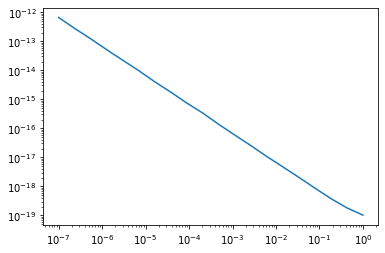

In [70]:
# -- Eeps --
#Two random vectors with same amplitude
a = np.random.randn(2*n**2).view(np.complex128).reshape((n,n))
a2 = np.random.randn(2*n**2).view(np.complex128).reshape((n,n))

ntest=20
tests = np.logspace(-7,0,ntest)
Dua = Du_Eeps(a,p)
real = []
approx = []
for t in tests:
    real.append(Du_Eeps(a+t*a2,p))
    approx.append(Dua+t*Du2_Eeps(a,p,a2))

plt.plot(tests,np.array([np.linalg.norm(real[i]-approx[i]) for i in range(ntest)])/tests)
plt.xscale("log")
plt.yscale("log")

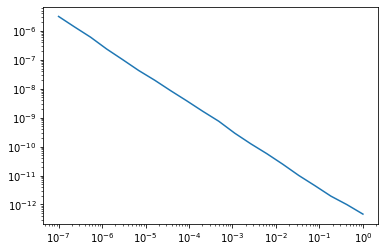

In [71]:
# -- Edata --
#Two random vectors with same amplitude
a = np.random.randn(2*n**2).view(np.complex128).reshape((n,n))
a2 = np.random.randn(2*n**2).view(np.complex128).reshape((n,n))

ntest=20
tests = np.logspace(-7,0,ntest)
real = []
approx = []
for t in tests:
    real.append(Du_Edata(a+t*a2,radial_p))
    approx.append(Du_Edata(a,radial_p)+Du2_Edata(a,radial_p,t*a2))

plt.plot(tests,np.array([np.linalg.norm(real[i]-approx[i]) for i in range(ntest)])/tests)
plt.xscale("log")
plt.yscale("log")

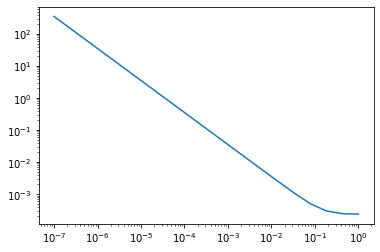

In [72]:
# -- Ereg --
#Two random vectors with same amplitude
a = np.random.randn(2*n**2).view(np.complex128).reshape((n,n))
a2 = np.random.randn(2*n**2).view(np.complex128).reshape((n,n))

ntest=20
tests = np.logspace(-7,0,ntest)
real = []
approx = []
for t in tests:
    real.append(Du_Ereg(a+t*a2,radial_p))
    approx.append(Du_Ereg(a,radial_p)+Du2_Ereg(a,radial_p,t*a2))

plt.plot(tests,np.array([np.linalg.norm(real[i]-approx[i]) for i in range(ntest)])/tests)
plt.xscale("log")
plt.yscale("log")

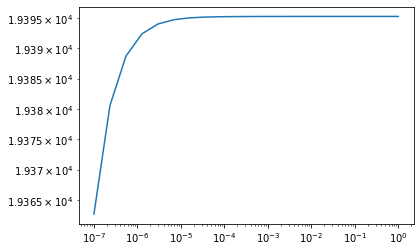

In [34]:
# -- Etot --
#Two random vectors with same amplitude
a = np.random.randn(n**2).reshape((n,n))
a=u0_mat
a2 = np.random.randn(n**2).reshape((n,n))

ntest=20
tests = np.logspace(-7,0,ntest)
real = []
approx = []
for t in tests:
    real.append(Du_Etot(a+t*a2))
    approx.append(Du_Etot(a)+Du2_Etot(a,p,t*a2))

plt.plot(tests,np.array([np.linalg.norm(real[i]-approx[i]) for i in range(ntest)])/tests)
plt.xscale("log")
plt.yscale("log")

## Cross derivatives

In [40]:
def Dpu_Edata(u,p,w):
    Fu = fourier_op.op(u)-y
    Fw = fourier_op.op(w)
    return 2*p[:-1]*(np.real(Fu)*np.real(Fw)+1j*np.imag(Fu)*np.imag(Fw))
def Dpu_Ereg(u,p,w):
    return p[-1]*np.sum(w*linear_op.adj_op(phi_vec(linear_op.op(u),param["gamma"])*linear_op.op(u)))

def Dpu_Etot(u,p,w):
    g = np.zeros((n**2+1,))
    g[:-1] = Dpu_Edata(u,p,w)
    g[-1] = 0
    return g

## Loss function and penalty

In [41]:
c = 1e5
def L(u,u2):return c*np.linalg.norm(u-u2)**2
def grad_L(u,u2):return 2*c*(u-u2)

beta = 1e-10*c
def P(p):return beta*np.linalg.norm(p[:-1])**2
def grad_P(p):
    Dp = 2*beta*p
    Dp[-1] = 0
    return Dp

# def P(p):return beta*np.sum(p[:-1]*(2-p[:-1]))
# def grad_P(p):
#     Dp = np.zeros(n**2+1)
#     Dp[:-1] = 2*beta*(1-p[:-1])
#     return Dp

In [42]:
param["pn1"]=1e-6
p = np.copy(radial_p)
uk,norms,energy = pdhg(y,p[:-1],fourier_op,linear_op,param,maxit=20,verbose=0)
print(f"L(u(p))={L(uk,u0_mat)}\nP(p)={P(p)}")

Finished in 0.16315650939941406 seconds.
L(u(p))=7.520597814477227e-05
P(p)=0.018789999999999998


# Upper level energy

In [43]:
uk = np.zeros(u0_mat.shape)

def E(pk):
    global uk
    print("\nEvaluating E(p)")
    param["pn1"]=pk[-1]
    uk,norms = pdhg(y,pk[:-1],fourier_op,linear_op,param,compute_energy=False,maxit=20,verbose=0)
    return L(uk,u0_mat)+P(pk)

cgconv = []
def grad_E(pk,max_cgiter=3000,tol=1e-8,compute_conv=False):
    global uk,cgconv
    #Update alpha(p)
    param["pn1"]=pk[-1]
    
    print("\nStarting PDHG")
    uk,norms = pdhg(y,pk[:-1],fourier_op,linear_op,param,compute_energy=False,maxit=30,verbose=0)
    
    def mv(w):
        w = np.reshape(w,(n,n))
        return np.reshape(Du2_Etot(uk,pk,w),(n**2,))
    
    
    # -- Use cg to compute gradient --
    lin = LinearOperator((n**2,n**2),matvec=mv)
    B = np.reshape(grad_L(uk,u0_mat),(n**2,))
    def cgcall(x):
        if compute_conv:cgconv.append(np.linalg.norm(lin(x)-B)/np.linalg.norm(B))
    
    t1=time.time()
    print("\nStarting Conjugate Gradient method")
    x_inter,convergence = cg(lin,B,tol=tol,maxiter=max_cgiter,callback=cgcall)
    print(f"Finished in {time.time()-t1}s - ||Ax-b||/||b||: {np.linalg.norm(lin(x_inter)-B)/np.linalg.norm(B)}")
    return Dpu_Etot(uk,pk,np.reshape(x_inter,(n,n)))+grad_P(pk)

# Callback function
niter = 0
def fcall(x):
    global uk,niter
    niter += 1
    print("\033[1m" + f"\n{niter} iterations: ssim={ssim(uk,u0_mat)}\n\n" + "\033[0m")

In [44]:
p0 = 0.9*radial_p+0.1*np.random.rand(n**2+1)
p0[-1]=1e-6
Ep0,gradEp0 = E(p0),grad_E(p0)
p1 = np.random.rand(n**2+1)

tests = np.logspace(-9,0,30)
real_values = np.array([E(p0+t*p1) for t in tests])
approx = np.array([Ep0+t*np.sum(gradEp0*p1) for t in tests])


Evaluating E(p)
Finished in 0.14330124855041504 seconds.

Starting PDHG
Finished in 0.19458794593811035 seconds.

Starting Conjugate Gradient method
Finished in 18.83064293861389s - ||Ax-b||/||b||: 10.745861482604703

Evaluating E(p)


/home/guillaume/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  # Remove the CWD from sys.path while we load stuff.


Finished in 0.15140771865844727 seconds.

Evaluating E(p)
Finished in 0.1392984390258789 seconds.

Evaluating E(p)
Finished in 0.14351844787597656 seconds.

Evaluating E(p)
Finished in 0.11125493049621582 seconds.

Evaluating E(p)
Finished in 0.12964534759521484 seconds.

Evaluating E(p)
Finished in 0.11279702186584473 seconds.

Evaluating E(p)
Finished in 0.1224064826965332 seconds.

Evaluating E(p)
Finished in 0.1108708381652832 seconds.

Evaluating E(p)
Finished in 0.12261772155761719 seconds.

Evaluating E(p)
Finished in 0.11117219924926758 seconds.

Evaluating E(p)
Finished in 0.12140059471130371 seconds.

Evaluating E(p)
Finished in 0.11019349098205566 seconds.

Evaluating E(p)
Finished in 0.12264752388000488 seconds.

Evaluating E(p)
Finished in 0.11066174507141113 seconds.

Evaluating E(p)
Finished in 0.12149381637573242 seconds.

Evaluating E(p)
Finished in 0.11151790618896484 seconds.

Evaluating E(p)
Finished in 0.12163162231445312 seconds.

Evaluating E(p)
Finished in 0.109

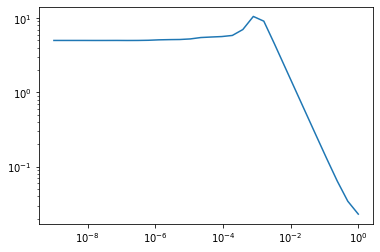

In [45]:
plt.plot(tests,abs((real_values-approx)/tests))
plt.xscale("log")
plt.yscale("log")

In [46]:
p[-1]=1e-6
gP = grad_E(p,max_cgiter=3000,tol=1e-10,compute_conv=True)


Starting PDHG
Finished in 0.23096227645874023 seconds.

Starting Conjugate Gradient method
Finished in 38.51053190231323s - ||Ax-b||/||b||: 113.44862467467156


/home/guillaume/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  # Remove the CWD from sys.path while we load stuff.


Text(0, 0.5, '||Ax-b||/||b||')

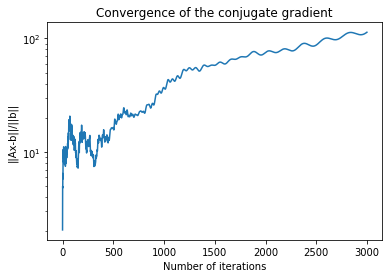

In [47]:
plt.plot(cgconv)
plt.yscale("log")
plt.title("Convergence of the conjugate gradient")
plt.xlabel("Number of iterations")
plt.ylabel("||Ax-b||/||b||")
#plt.savefig("Upper Level/CG_conv.png")

In [29]:
np.amax(gP)

0.0007879822968705285

# L-BFGS-B

In [30]:
p0 = 0.9*p+0.1*np.random.rand(n**2+1)
# p0 = np.random.rand(n**2+1)
# p0=np.ones(n**2+1)
p0[-1] = 1e-6

In [31]:
niter = 0
pf,Emin,info = fmin_l_bfgs_b(E,p,grad_E,bounds=[(0,1)]*n**2+[(0,np.inf)],pgtol=1e-15,
                           maxfun=1000,maxiter=1000,
                            callback = fcall)


Evaluating E(p)
Finished in 0.16618585586547852 seconds.

Starting PDHG
Finished in 0.15309500694274902 seconds.

Starting Conjugate Gradient method


KeyboardInterrupt: 

In [ ]:
print(E(p0),E(pf))

In [ ]:
print(pf[-1])
pysap.Image(data=np.reshape(pf[:-1],(n,n))).show()

In [ ]:
np.sum(p0),np.sum(pf)

In [ ]:
uk,norms,energy,ssims = pdhg(y,pf[:-1],fourier_op,linear_op,param,real_image=u0_mat,maxit=100)
print(ssim(uk,u0_mat))

plt.figure()
plt.plot(ssims)
plt.title("Evolution of ssim")
plt.show()

plt.figure()
plt.plot(energy)
plt.title("Evolution of energy")
plt.yscale("log")
plt.show()

pysap.Image(data=uk).show()